**Conecting to Drive**

In [1]:
from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

drive.mount('/content/drive')

Mounted at /content/drive


# modules

## Data

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# load data with scipy.io:
path = '/content/drive/MyDrive/Colab Notebooks/Mestrado/Design and analysis of recurrent neural networks for ultrafast optical pulses nonlinear propagation (2022)'

def load_data(X, ts=10, scaler=None, split=True, shuffle=True, train_size=2900, seed=0):
  # for reproducibility
  np.random.seed(seed=seed)

  # steps, features, num_simulations
  N, F, S = X.shape
  N = N - ts
  ts += 1

  # data
  data = np.zeros((S*N,ts,F))
  
  s = 0
  if shuffle:
    range_S = np.arange(S)
    np.random.shuffle(range_S)
    for m in range_S:
      for n in range(N):
        data[s] = X[n:n+ts,:,m]
        s += 1
  else:
    for m in range(S):
      for n in range(N):
        data[s] = X[n:n+ts,:,m]
        s += 1
 
  # normalize data
  if scaler == None:
    scaler = MinMaxScaler()
    norm = scaler.fit_transform(data.reshape([-1,1]))
  else:
    norm = scaler.transform(data.reshape([-1,1]))

  # dataset division:
  data = norm.reshape(data.shape)
  x_data = data[:,0:ts-1,:]
  y_data = data[:,ts-1,:]

  if split:
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=train_size*N, shuffle=False)
  else:
    x_test, y_test = x_data, y_data

  return x_test, y_test, scaler

In [3]:
def split(ary, indices_or_sections=1, offset=0):
  if ary.ndim == 2:
    S,M = ary.shape
    ary = ary.reshape((indices_or_sections,int(S/indices_or_sections),M))
    ary = ary[:,offset:]
    ary = ary.reshape((indices_or_sections*int(S/indices_or_sections - offset),M))
  elif ary.ndim == 3:
    S,M,N = ary.shape
    ary = ary.reshape((indices_or_sections,int(S/indices_or_sections),M,N))
    ary = ary[:,offset:]
    ary = ary.reshape((indices_or_sections*int(S/indices_or_sections - offset),M,N))
  return ary

## Model

In [4]:
import tensorflow as tf

def build_model(X, y, units=512, a='relu'):
  # define model architecture
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.LSTM(units, activation=a, input_shape=X.shape[1:]))
  model.add(tf.keras.layers.Dense(161, activation='relu'))
  model.add(tf.keras.layers.Dense(161, activation='relu'))
  model.add(tf.keras.layers.Dense(y.shape[1], activation='sigmoid'))
  return model

## Metrics

In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

def norm_mean_squared_error(y_test, y_pred):
  return np.sqrt(np.sum((y_test - y_pred)**2)/np.sum(y_test**2))

def metrics(y_test, y_pred):
  # Metrics
  MSE = mean_squared_error(y_test, y_pred, squared=True)
  RMSE = mean_squared_error(y_test, y_pred, squared=False)
  NRMSE = norm_mean_squared_error(y_test, y_pred)
  R2 = r2_score(y_test, y_pred)
  MAE = mean_absolute_error(y_test, y_pred)

  print('RMSE = %.6f' % RMSE)
  print('NRMSE = %.6f' % NRMSE)
  print('MSE  = %.6f' % MSE)
  print('MAE  = %.6f' % MAE)
  print('R2   = %.6f' % R2)

def predict(model, x_test, N=90, input_only=False):
  batch, timesteps, feature = x_test.shape

  if input_only:
    x_pred = x_test
  else:
    x_pred = x_test[0::N]
  y_pred = np.zeros((batch, 1, feature))

  # 'cold' start
  for n in range(timesteps):
    x_pred[:,n,:] = x_pred[:,0,:] # repeat inputs
    
  # predict
  for n in range(N):
    y_pred[n::N,0,:] = model.predict(x_pred)
    x_pred = np.concatenate((x_pred[:,1:,:], y_pred[n::N]), axis=1)

  return y_pred.squeeze()

# Figures

In [ ]:
def index(I, num=75):
  m = int(I/num)                          # power
  n = I - int(I/num)*num                  # timewidth
  return m, n

#@title Pulse Input { run: "auto", vertical-output: true, display-mode: "form" }
I = 52 #@param {type:"slider", min:0, max:99, step:1}

# inputs
P0     = np.linspace(18.41, 34.19, num=40)      # Peak power
T_FWHM = np.linspace(0.77, 1.43, num=75)        # FWHM

# for reproducibility
np.random.seed(0)

r = np.arange(3000)
np.random.shuffle(r)
r = r[2900:]

m,n = index(r[I])

print(r.shape)
print('P0 = %.2f' % P0[m], 'W;', 'T_FWHM = %.2f' % T_FWHM[n], 'ps')

(100,)
P0 = 34.19 W; T_FWHM = 0.81 ps


## Soliton (time)

In [ ]:
# load data
data = sio.loadmat(path + '/data/sech_time.mat')['data']

# data params
ts = 10             # window size
N = 101 - ts        # steps

# test dataset
x_test, y_test, scaler = load_data(data, ts)

# build model
units = 512
model = build_model(x_test, y_test, units=units)
model.load_weights(path + '/nets/LSTM512_2Dense161_ts10_sech_time.h5')

# Evolution prediction:
y_pred = predict(model, x_test, N)

# Metrics
metrics(y_test, y_pred)

KeyboardInterrupt: ignored

In [ ]:
y_true = scaler.inverse_transform(y_test)
y_fake = scaler.inverse_transform(y_pred)

### Temporal evolution

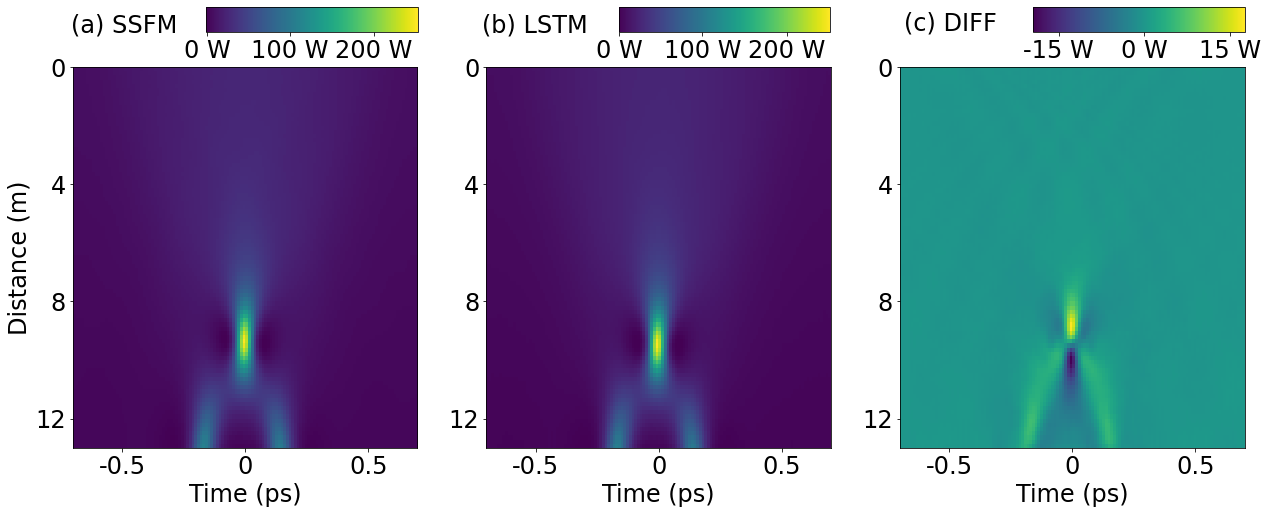

In [ ]:
fontsize = 24

fig, ax = plt.subplots(figsize=(21,7))

plt.subplot(131)
plt.imshow(y_true[I*N:N+N*I], interpolation='nearest', aspect='auto', extent=[-.7,.7,13,0])
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([0,4,8,12], ['0','4','8','12'], fontsize=fontsize)
plt.xlabel('Time (ps)', fontsize=fontsize)
plt.ylabel('Distance (m)', fontsize=fontsize)
plt.xticks()

cax = plt.axes([0.213, 0.95, 0.14, 0.05])
cbar = plt.colorbar(cax=cax, orientation='horizontal', ticks=[2,100,200])
cbar.ax.set_xticklabels(['0 W', '100 W', '200 W'], fontsize=fontsize)
plt.text(-160, 0, '(a) SSFM', fontsize=fontsize)

plt.subplot(132)
plt.imshow(y_fake[I*N:N+N*I], interpolation='nearest', aspect='auto', extent=[-.7,.7,13,0])
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([0,4,8,12], ['0','4','8','12'], fontsize=fontsize)
plt.xlabel('Time (ps)', fontsize=fontsize)

cax = plt.axes([0.486, 0.95, 0.14, 0.05])
cbar = plt.colorbar(cax=cax, orientation='horizontal', ticks=[2,100,200])
cbar.ax.set_xticklabels(['0 W', '100 W', '200 W'], fontsize=fontsize)
plt.text(-160, 0, '(b) LSTM', fontsize=fontsize)

plt.subplot(133)
plt.imshow(y_true[I*N:N+N*I] - y_fake[I*N:N+N*I], interpolation='nearest', aspect='auto', extent=[-.7,.7,13,0])
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([0,4,8,12], ['0','4','8','12'], fontsize=fontsize)
plt.xlabel('Time (ps)', fontsize=fontsize)

cax = plt.axes([0.76, 0.95, 0.14, 0.05])
cbar = plt.colorbar(cax=cax, orientation='horizontal', ticks=[-15,0,15])
cbar.ax.set_xticklabels(['-15 W','0 W','15 W'], fontsize=fontsize)
plt.text(-42, -17, '(c) DIFF', fontsize=fontsize)

# plt.savefig('fig1.eps')

### Pulse shape

Text(-0.7, 220, 'z = 10.0 m')

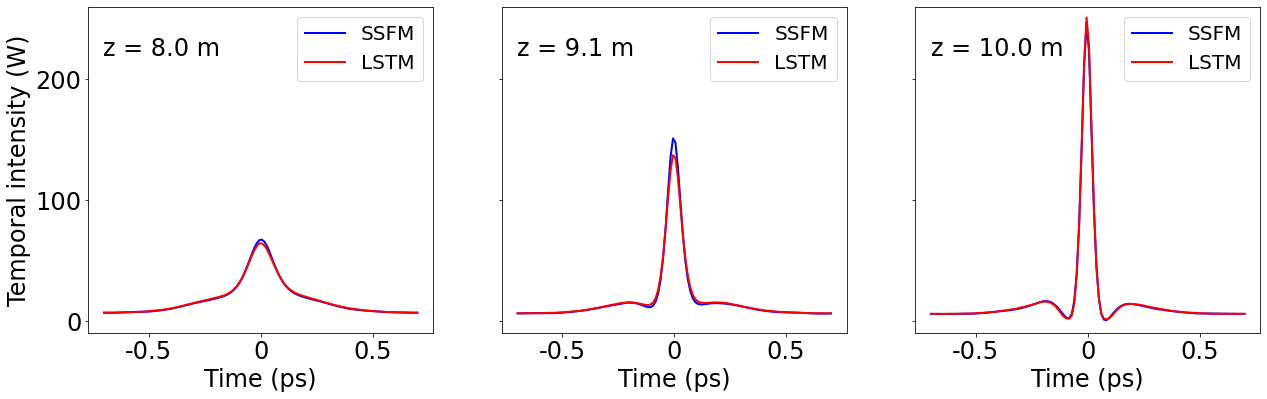

In [ ]:
fontsize = 24
t = np.linspace(-0.7,0.7,128)

deltaz = .13; M = 101
L = np.linspace(deltaz*ts, deltaz*M, N)

# plot
plt.figure(figsize=(21,6))
plt.subplot(1,3,1)
plt.plot(t, y_true[I*N + 51], 'b', label='SSFM', linewidth=2)
plt.plot(t, y_fake[I*N + 51], 'r', label='LSTM', linewidth=2)
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([0,100,200], ['0','100','200'], fontsize=fontsize)
plt.xlabel('Time (ps)', fontsize=fontsize)
plt.ylabel('Temporal intensity (W)', fontsize=fontsize)
plt.ylim([-10, 260])
plt.legend(fontsize=20)

plt.subplot(1,3,2)
plt.plot(t, y_true[I*N + 59], 'b', label='SSFM', linewidth=2)
plt.plot(t, y_fake[I*N + 59], 'r',label='LSTM', linewidth=2)
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([0,100,200], [])
plt.xlabel('Time (ps)', fontsize=fontsize)
plt.ylim([-10, 260])
plt.legend(fontsize=20)

plt.subplot(1,3,3)
plt.plot(t, y_true[I*N + 66], 'b', label='SSFM', linewidth=2)
plt.plot(t, y_fake[I*N + 66], 'r', label='LSTM', linewidth=2)
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([0,100,200], [])
plt.xlabel('Time (ps)', fontsize=fontsize)
plt.ylim([-10, 260])
plt.legend(fontsize=20)

plt.text(-4.4, 220, 'z = %.1f m' % L[51], fontsize=fontsize)
plt.text(-2.55, 220, 'z = %.1f m' % L[59], fontsize=fontsize)
plt.text(-.7, 220, 'z = %.1f m' % L[66], fontsize=fontsize)

# plt.savefig('fig2.eps')

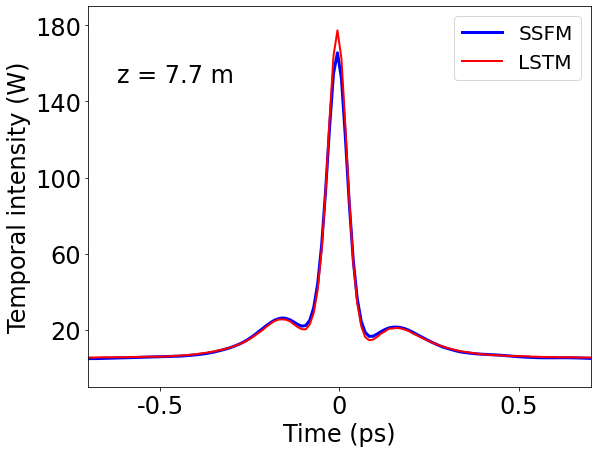

In [ ]:
fontsize = 24
t = np.linspace(-0.7,0.7,128)

deltaz = .13; M = 101
L = np.linspace(deltaz*ts, deltaz*M, N)

# plot
plt.figure(figsize=[9, 7])
plt.plot(t, y_true[I*N + 49], 'b', label='SSFM', lw=3)
plt.plot(t, y_fake[I*N + 49], 'r', label='LSTM', lw=2)
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([20,60,100,140,180], fontsize=fontsize)
plt.xlabel('Time (ps)', fontsize=fontsize)
plt.ylabel('Temporal intensity (W)', fontsize=fontsize)
plt.xlim([-.7,.7])
plt.ylim([-10, 190])
plt.legend(fontsize=20)

plt.text(-.62, 150, 'z = %.1f m' % L[49], fontsize=fontsize)

plt.savefig('figure3.eps')

In [ ]:
ypred = predict(model, x_test[I*N:I*N+N],N)
metrics(y_pred=ypred,y_test=y_test[I*N:I*N+N])

RMSE = 0.001897
NRMSE = 0.033064
MSE  = 0.000007
MAE  = 0.001420
R2   = 0.975979


## Soliton (spec)

In [ ]:
# load data
sech_spec = sio.loadmat(path + '/data/sech_spec.mat')['data']

# data params
ts = 10             # window size
N = 101 - ts        # steps

# test dataset
x_test, y_test, scaler = load_data(sech_spec, ts)

# build model
model = build_model(x_test, y_test, 300)

# model.load_weights(path + '/nets/LSTM768_2Dense161_ts10_spec.h5')
model.load_weights(path + '/nets/LSTM300_2Dense161_ts10_spec.h5')

# Evolution prediction:
y_pred = predict(model, x_test, N)

# Metrics
metrics(y_test, y_pred)

RMSE = 0.012449
NRMSE = 0.290047
MSE  = 0.000422
MAE  = 0.007976
R2   = 0.453516


In [ ]:
y_true = scaler.inverse_transform(y_test)
y_fake = scaler.inverse_transform(y_pred)

### Spectral evolution (linear)

Text(0.5, 0, 'Time (ps)')

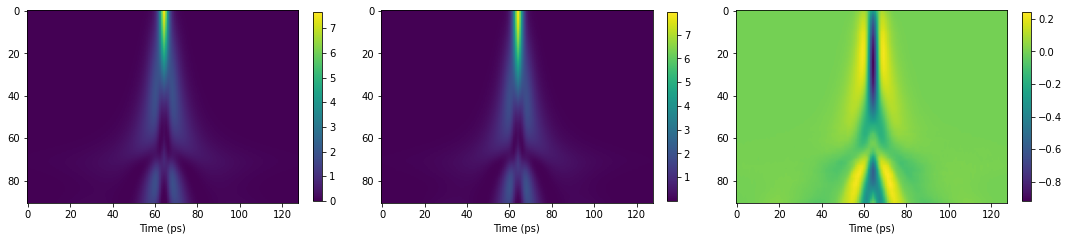

In [ ]:
# plot
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(y_true[I*N:N+N*I])
plt.colorbar(fraction=0.032)
plt.xlabel('Time (ps)')

plt.subplot(1,3,2)
plt.imshow(y_fake[I*N:N+N*I])
plt.colorbar(fraction=0.032)
plt.xlabel('Time (ps)')
# plt.title('P0 = %.2f W, ' % P0[m] + 'T_FWHM = %.2f ps' % T_FWHM[n])

plt.subplot(1,3,3)
plt.imshow(y_true[I*N:N+N*I] - y_fake[I*N:N+N*I])
plt.colorbar(fraction=0.032)
plt.xlabel('Time (ps)')

### Spectrum shape (linear)

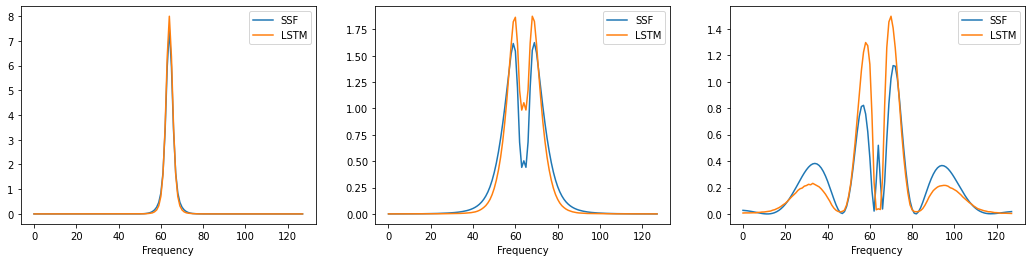

In [ ]:
# plot
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(y_true[I],label='SSF')
plt.plot(y_fake[I], label='LSTM')
plt.xlabel('Frequency')
plt.legend()

plt.subplot(1,3,2)
plt.plot(y_true[45],label='SSF')
plt.plot(y_fake[45], label='LSTM')
# plt.title('P0 = %.2f W, ' % P0[m] + 'T_FWHM = %.2f ps' % T_FWHM[n])
plt.xlabel('Frequency')
plt.legend()

plt.subplot(1,3,3)
plt.plot(y_true[N-1],label='SSF')
plt.plot(y_fake[N-1], label='LSTM')
plt.xlabel('Frequency')
plt.legend()

### Spectrum shape (dB)

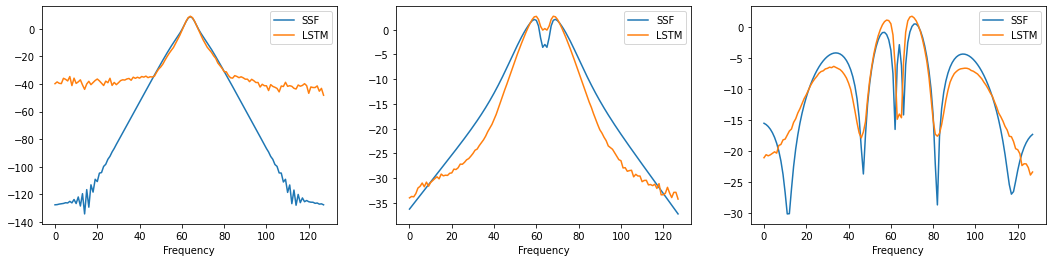

In [ ]:
# plot
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(10*np.log10(y_true[I]), label='SSF')
plt.plot(10*np.log10(y_fake[I]), label='LSTM')
plt.xlabel('Frequency')
plt.legend()

plt.subplot(1,3,2)
plt.plot(10*np.log10(y_true[45]), label='SSF')
plt.plot(10*np.log10(y_fake[45]), label='LSTM')
# plt.title('P0 = %.2f W, ' % P0[m] + 'T_FWHM = %.2f ps' % T_FWHM[n])
plt.xlabel('Frequency')
plt.legend()

plt.subplot(1,3,3)
plt.plot(10*np.log10(y_true[N-1]), label='SSF')
plt.plot(10*np.log10(y_fake[N-1]), label='LSTM')
plt.xlabel('Frequency')
plt.legend()

## Fiber Length

In [ ]:
# load data
sech_L52m_time = sio.loadmat(path + '/data/sech_L52m_time.mat')['data']

# data params
ts = 10             # window size

# test dataset
x_test, y_test, scaler = load_data(sech_L52m_time[0:11], ts)

print(x_test.shape, y_test.shape)

# build model
model = build_model(x_test, y_test, units=512, a='tanh')
model.load_weights(path + '/nets/LSTM512_2Dense161_ts10_sech_time.h5')

(100, 10, 128) (100, 128)


### Step-by-Step

In [ ]:
from sklearn.metrics import mean_squared_error

score_step = []
score_avrg = []

deltaz = .13
M = 121
N = M - ts
L = np.linspace(deltaz*ts, deltaz*M, N)

x_test, y_test, scaler = load_data(sech_L52m_time[:M], ts)
print(x_test.shape, y_test.shape)

for n in range(N):
  # Step-by-Step prediction:
  y_pred = model.predict(x_test[n::N])

  # Metrics
  RMSE = mean_squared_error(y_test[n::N], y_pred, squared=False)

  score_step.append(RMSE)
  score_avrg.append(np.mean(score_step))


(11100, 10, 128) (11100, 128)


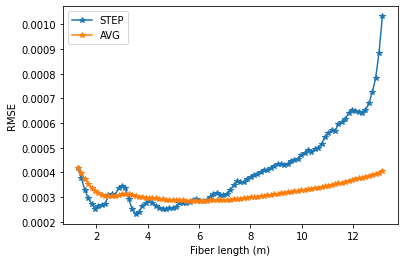

In [ ]:
# plot
plt.figure()
plt.plot(L, score_step, '*-', label='STEP')
plt.plot(L, score_avrg, '*-', label='AVG')
plt.xlabel('Fiber length (m)')
plt.ylabel('RMSE')
plt.legend()

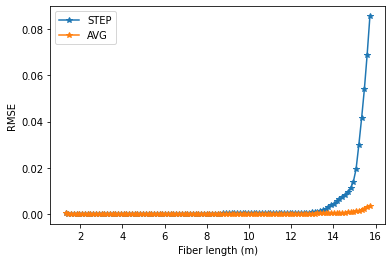

In [ ]:
# plot
plt.figure()
plt.plot(L, score_step, '*-', label='STEP')
plt.plot(L, score_avrg, '*-', label='AVG')
plt.xlabel('Fiber length (m)')
plt.ylabel('RMSE')
plt.legend()

### Input only

In [ ]:
from sklearn.metrics import mean_squared_error

score_step = []
score_avrg = []

deltaz = .13
M = 116
N = M - ts
L = np.linspace(deltaz*ts, deltaz*M, N)

x_test, y_test, scaler = load_data(sech_L52m_time[:M], ts)
print(x_test.shape, y_test.shape)

# prediction:
y_pred = predict(model, x_test, N)

for n in range(N):
  # Metrics
  RMSE = mean_squared_error(y_test[n::N], y_pred[n::N], squared=False)

  score_step.append(RMSE)
  score_avrg.append(np.mean(score_step))


(10600, 10, 128) (10600, 128)


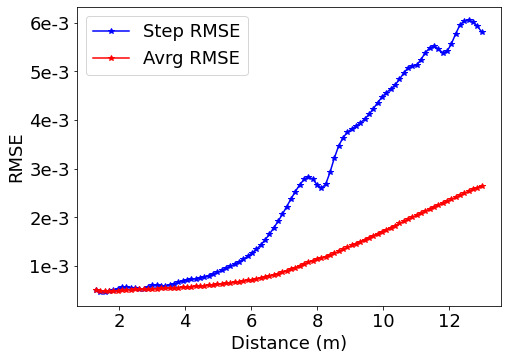

In [ ]:
fontsize = 18
lo = 90
# plot
plt.figure(figsize=[7.6, 5.5])
plt.plot(L[:lo], score_step[:lo], '*-b', label='Step RMSE')
plt.plot(L[:lo], score_avrg[:lo], '*-r', label='Avrg RMSE')
plt.xticks([2, 4, 6, 8, 10, 12],['2', '4', '6', '8', '10', '12'], fontsize=fontsize)
plt.yticks([1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3],['1e-3', '2e-3', '3e-3', '4e-3', '5e-3', '6e-3'], fontsize=fontsize)
plt.xlabel('Distance (m)', fontsize=fontsize)
plt.ylabel('RMSE', fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.savefig('len1.eps')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


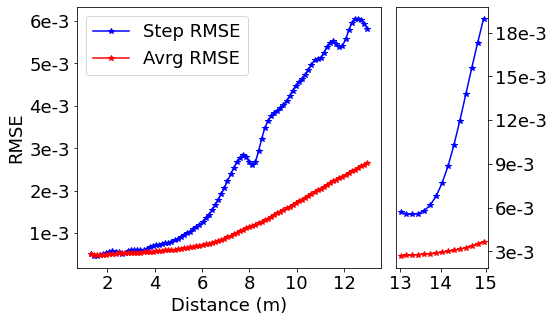

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fontsize = 18
lo = 90; lf = 105

# plot
fig = plt.figure(figsize=[12, 4.8])
plt.subplot(121)
plt.plot(L[:lo], score_step[:lo], '*-b', label='Step RMSE')
plt.plot(L[:lo], score_avrg[:lo], '*-r', label='Avrg RMSE')
plt.xticks([2, 4, 6, 8, 10, 12],['2', '4', '6', '8', '10', '12'], fontsize=fontsize)
plt.yticks([1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3],['1e-3', '2e-3', '3e-3', '4e-3', '5e-3', '6e-3'], fontsize=fontsize)
plt.xlabel('Distance (m)', fontsize=fontsize)
plt.ylabel('RMSE', fontsize=fontsize)
plt.legend(fontsize=fontsize)

ax = fig.add_subplot(121)

a1 = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(1.05, 0, .3, 1),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
a1.tick_params(left=False, right=True, labelleft=False, labelright=True)
# plt.figure(figsize=[6.9, 4.8])
# plt.subplot(122)
a1.plot(L[lo:lf], score_step[lo:lf], '*-b')
a1.plot(L[lo:lf], score_avrg[lo:lf], '*-r')
plt.xticks([13.1, 14, 15],['13', '14', '15'], fontsize=fontsize)
plt.yticks([3e-3, 6e-3, 9e-3, 12e-3, 15e-3, 18e-3],['3e-3', '6e-3', '9e-3', '12e-3', '15e-3', '18e-3'], fontsize=fontsize)

plt.savefig('len2.eps')

### Evolution

In [ ]:
from sklearn.metrics import mean_squared_error

score_evo = []

deltaz = .13
M = 133
N = M - ts

L = np.linspace(deltaz*ts, deltaz*M, N)

x_test, y_test, scaler = load_data(sech_L52m_time[:M], ts)
val = np.zeros(y_test.shape, dtype=bool)

# prediction:
y_pred = predict(model, x_test, N)

for n in range(N):
  # Metrics
  val[n::N] = True
  RMSE = mean_squared_error(y_test[val], y_pred[val], squared=False)

  score_evo.append(RMSE)


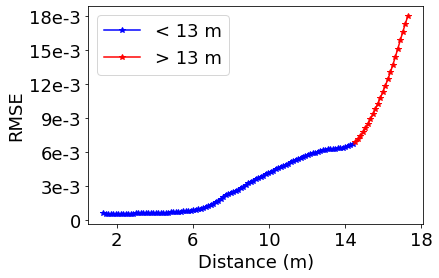

In [ ]:
fontsize=18

# plot
plt.figure()
plt.plot(L[:101], score_evo[:101], '*-b', label='< 13 m')
plt.plot(L[101:], score_evo[101:], '*-r', label='> 13 m')
plt.xticks([2, 6, 10, 14, 18],['2', '6', '10', '14', '18'], fontsize=fontsize)
plt.yticks([0, 3e-3, 6e-3, 9e-3, 12e-3, 15e-3, 18e-3],['0', '3e-3', '6e-3', '9e-3', '12e-3', '15e-3', '18e-3'], fontsize=fontsize)
plt.xlabel('Distance (m)', fontsize=fontsize)
plt.ylabel('RMSE', fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [ ]:
y_true = scaler.inverse_transform(y_test)
y_fake = scaler.inverse_transform(y_pred)

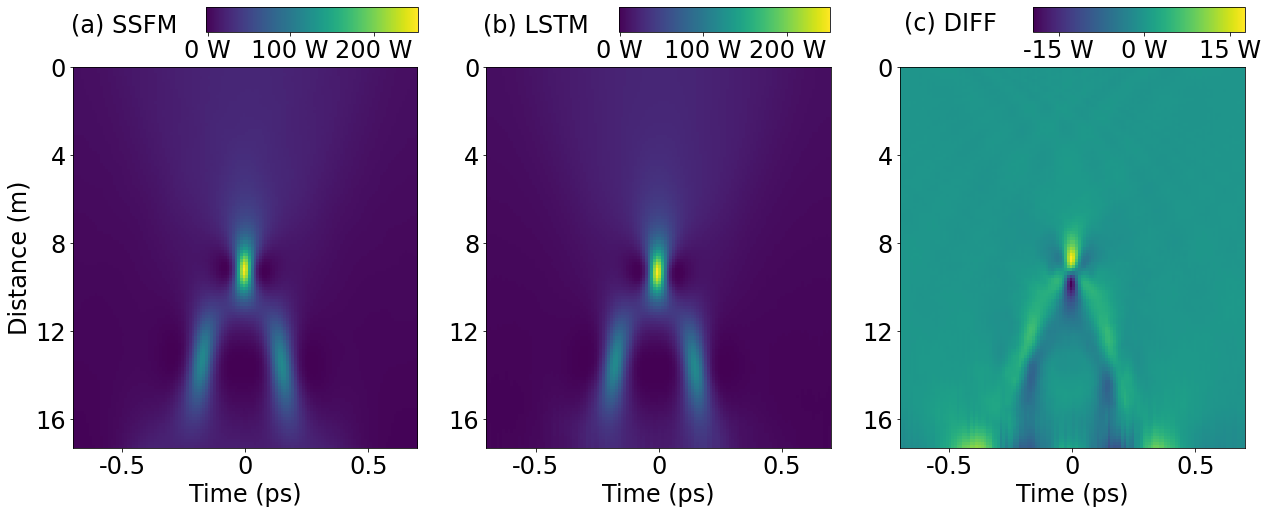

In [ ]:
fontsize = 24

fig, ax = plt.subplots(figsize=(21,7))

plt.subplot(131)
plt.imshow(y_true[I*N:N+N*I], interpolation='nearest', aspect='auto', extent=[-.7,.7,L[-1],0])
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([0,4,8,12,16], ['0','4','8','12','16'], fontsize=fontsize)
plt.xlabel('Time (ps)', fontsize=fontsize)
plt.ylabel('Distance (m)', fontsize=fontsize)
plt.xticks()

cax = plt.axes([0.213, 0.95, 0.14, 0.05])
cbar = plt.colorbar(cax=cax, orientation='horizontal', ticks=[2,100,200])
cbar.ax.set_xticklabels(['0 W', '100 W', '200 W'], fontsize=fontsize)
plt.text(-160, 0, '(a) SSFM', fontsize=fontsize)

plt.subplot(132)
plt.imshow(y_fake[I*N:N+N*I], interpolation='nearest', aspect='auto', extent=[-.7,.7,L[-1],0])
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([0,4,8,12,16], ['0','4','8','12','16'], fontsize=fontsize)
plt.xlabel('Time (ps)', fontsize=fontsize)

cax = plt.axes([0.486, 0.95, 0.14, 0.05])
cbar = plt.colorbar(cax=cax, orientation='horizontal', ticks=[2,100,200])
cbar.ax.set_xticklabels(['0 W', '100 W', '200 W'], fontsize=fontsize)
plt.text(-160, 0, '(b) LSTM', fontsize=fontsize)

plt.subplot(133)
plt.imshow(y_true[I*N:N+N*I] - y_fake[I*N:N+N*I], interpolation='nearest', aspect='auto', extent=[-.7,.7,L[-1],0])
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([0,4,8,12,16], ['0','4','8','12','16'], fontsize=fontsize)
plt.xlabel('Time (ps)', fontsize=fontsize)

cax = plt.axes([0.76, 0.95, 0.14, 0.05])
cbar = plt.colorbar(cax=cax, orientation='horizontal', ticks=[-15,0,15])
cbar.ax.set_xticklabels(['-15 W','0 W','15 W'], fontsize=fontsize)
plt.text(-42, -17, '(c) DIFF', fontsize=fontsize)

# plt.savefig('fig4.pdf')
plt.savefig('fig4.eps')

## Gaussian (time)

In [ ]:
# load data
gaussian_time = sio.loadmat(path + '/data/gaussian_time.mat')['data']

# data params
ts = 10             # window size
N = 101 - ts        # steps

# test dataset
x_test, y_test, scaler = load_data(gaussian_time, ts)

# build model
model = build_model(x_test, y_test, 512)
model.load_weights(path + '/nets/LSTM512_2Dense161_ts10_gaus_time.h5')

# Evolution prediction:
y_pred = predict(model, x_test, N)

# Metrics
metrics(y_test, y_pred)

RMSE = 0.003310
NRMSE = 0.140487
MSE  = 0.000042
MAE  = 0.001696
R2   = 0.976934


In [ ]:
y_true = scaler.inverse_transform(y_test)
y_fake = scaler.inverse_transform(y_pred)

### Temporal evolution

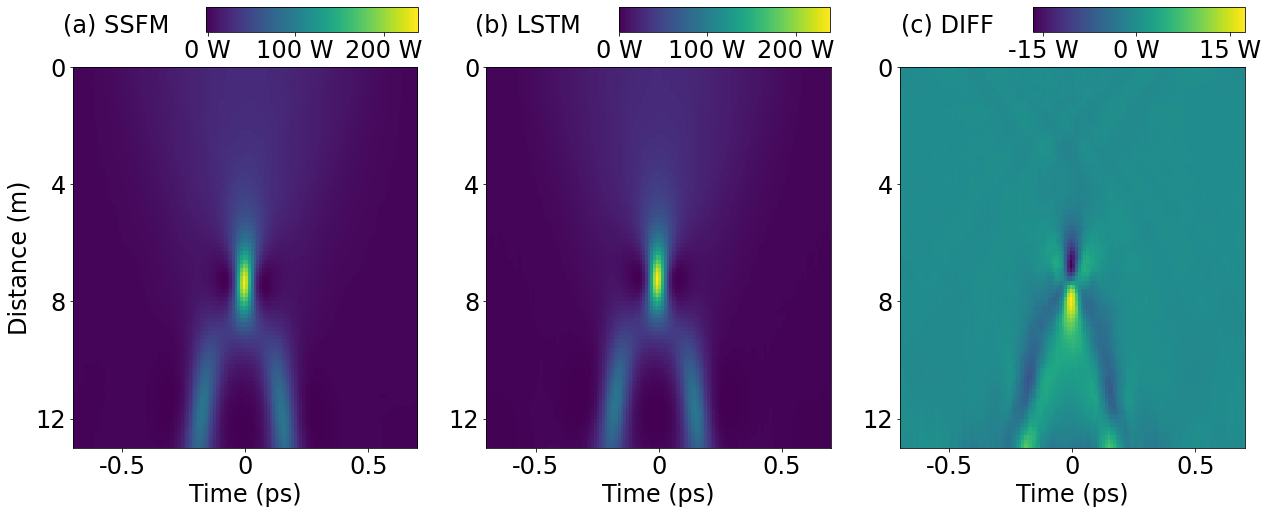

In [ ]:
fontsize = 24

fig, ax = plt.subplots(figsize=(21,7))

plt.subplot(131)
plt.imshow(y_true[I*N:N+N*I], interpolation='nearest', aspect='auto', extent=[-.7,.7,13,0])
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([0,4,8,12], ['0','4','8','12'], fontsize=fontsize)
plt.xlabel('Time (ps)', fontsize=fontsize)
plt.ylabel('Distance (m)', fontsize=fontsize)
plt.xticks()

cax = plt.axes([0.213, 0.95, 0.14, 0.05])
cbar = plt.colorbar(cax=cax, orientation='horizontal', ticks=[2,100,200])
cbar.ax.set_xticklabels(['0 W', '100 W', '200 W'], fontsize=fontsize)
plt.text(-160, 0, '(a) SSFM', fontsize=fontsize)

plt.subplot(132)
plt.imshow(y_fake[I*N:N+N*I], interpolation='nearest', aspect='auto', extent=[-.7,.7,13,0])
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([0,4,8,12], ['0','4','8','12'], fontsize=fontsize)
plt.xlabel('Time (ps)', fontsize=fontsize)

cax = plt.axes([0.486, 0.95, 0.14, 0.05])
cbar = plt.colorbar(cax=cax, orientation='horizontal', ticks=[2,100,200])
cbar.ax.set_xticklabels(['0 W', '100 W', '200 W'], fontsize=fontsize)
plt.text(-160, 0, '(b) LSTM', fontsize=fontsize)

plt.subplot(133)
plt.imshow(y_true[I*N:N+N*I] - y_fake[I*N:N+N*I], interpolation='nearest', aspect='auto', extent=[-.7,.7,13,0])
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([0,4,8,12], ['0','4','8','12'], fontsize=fontsize)
plt.xlabel('Time (ps)', fontsize=fontsize)

cax = plt.axes([0.76, 0.95, 0.14, 0.05])
cbar = plt.colorbar(cax=cax, orientation='horizontal', ticks=[-15,0,15])
cbar.ax.set_xticklabels(['-15 W','0 W','15 W'], fontsize=fontsize)
plt.text(-38, -17, '(c) DIFF', fontsize=fontsize)

plt.savefig('fig-gaus.eps')

### Pulse shape

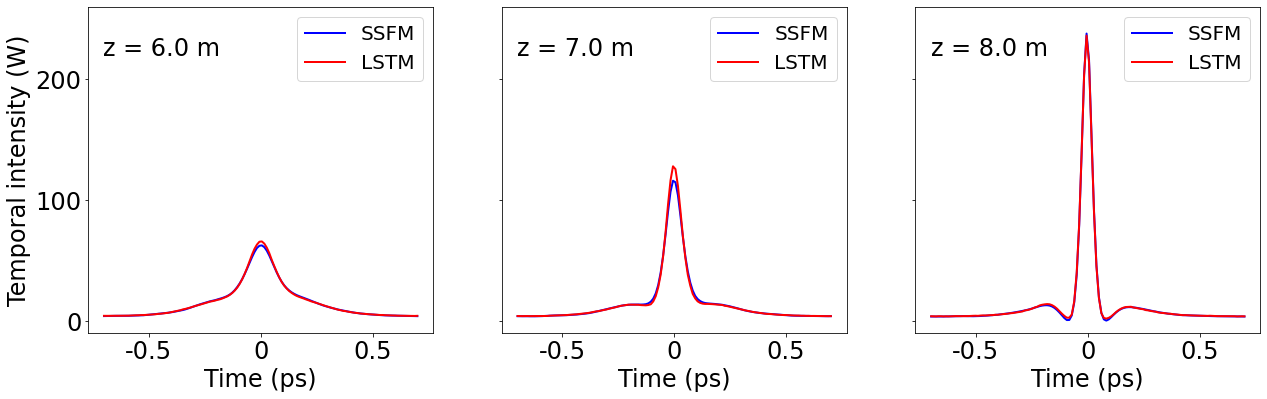

In [ ]:
fontsize = 24
t = np.linspace(-0.7,0.7,128)

deltaz = .13; M = 101
L = np.linspace(deltaz*ts, deltaz*M, N)

# plot
plt.figure(figsize=(21,6))
plt.subplot(1,3,1)
plt.plot(t, y_true[I*N + 36], 'b', label='SSFM', linewidth=2)
plt.plot(t, y_fake[I*N + 36], 'r', label='LSTM', linewidth=2)
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([0,100,200], ['0','100','200'], fontsize=fontsize)
plt.xlabel('Time (ps)', fontsize=fontsize)
plt.ylabel('Temporal intensity (W)', fontsize=fontsize)
plt.ylim([-10, 260])
plt.legend(fontsize=20)

plt.subplot(1,3,2)
plt.plot(t, y_true[I*N + 43], 'b', label='SSFM', linewidth=2)
plt.plot(t, y_fake[I*N + 43], 'r',label='LSTM', linewidth=2)
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([0,100,200], [])
plt.xlabel('Time (ps)', fontsize=fontsize)
plt.ylim([-10, 260])
plt.legend(fontsize=20)

plt.subplot(1,3,3)
plt.plot(t, y_true[I*N + 51], 'b', label='SSFM', linewidth=2)
plt.plot(t, y_fake[I*N + 51], 'r', label='LSTM', linewidth=2)
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([0,100,200], [])
plt.xlabel('Time (ps)', fontsize=fontsize)
plt.ylim([-10, 260])
plt.legend(fontsize=20)

plt.text(-4.4, 220, 'z = %.1f m' % L[36], fontsize=fontsize)
plt.text(-2.55, 220, 'z = %.1f m' % L[43], fontsize=fontsize)
plt.text(-.7, 220, 'z = %.1f m' % L[51], fontsize=fontsize)

plt.savefig('fig2-gaus.eps')

## Wider Range

### Po < 35 W

In [ ]:
# load data
sech_time = sio.loadmat(path + '/data/sech_time.mat')['data']

# data params
ts = 10             # window size
N = 101 - ts        # steps

# test dataset
x_test, y_test, scaler = load_data(sech_time, ts)

# build model
model = build_model(x_test, y_test, 512)
model.load_weights(path + '/nets/LSTM512_2Dense161_ts10_sech_time.h5')

In [ ]:
from sklearn.metrics import mean_squared_error

score_step = []

M = 101
N = M - ts

x_test, y_test, scaler = load_data(sech_time, ts, train_size=2625, shuffle=False)

x_evo = np.split(x_test, 375)
y_evo = np.split(y_test, 375)

for n in range(0,375,5):
  # Metrics
  y_pred = predict(model, x_evo[n], N)
  RMSE = mean_squared_error(y_evo[n], y_pred, squared=False)

  score_step.append(RMSE)


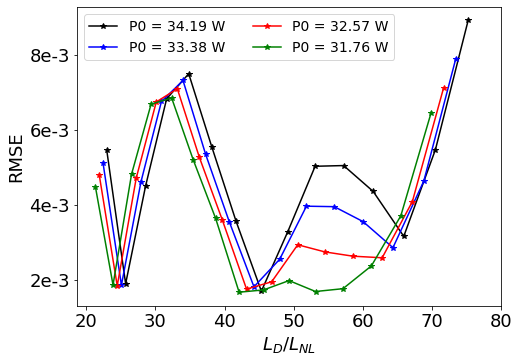

In [ ]:
fontsize = 18

def nl_ratio(P0,T0):
  return (18.4e-3/5.23e-27)*P0*T0**2

T_fwhm = np.linspace(0.77e-12, 1.43e-12, 75)
T0 = T_fwhm/(2*np.log(1+np.sqrt(2)))

# plot
plt.figure(figsize=[7.6, 5.5])
plt.plot(nl_ratio(34.19, T0[0:75:5]), score_step[60:75], '*-k', label='P0 = 34.19 W')
plt.plot(nl_ratio(33.38, T0[0:75:5]), score_step[45:60], '*-b', label='P0 = 33.38 W')
plt.plot(nl_ratio(32.57, T0[0:75:5]), score_step[30:45], '*-r', label='P0 = 32.57 W')
plt.plot(nl_ratio(31.76, T0[0:75:5]), score_step[15:30], '*-g', label='P0 = 31.76 W')
# plt.plot(nl_ratio(30.95, T0[0:75:5]), score_step[00:15], '*-r', label='P0 = 30.95 W')
plt.xticks([20,30,40,50,60,70,80],['20','30','40','50','60','70','80'], fontsize=fontsize)
plt.yticks([2e-3,4e-3,6e-3,8e-3],['2e-3','4e-3','6e-3','8e-3'], fontsize=fontsize)
plt.xlabel(r'$L_D/L_{NL}$', fontsize=fontsize)
plt.ylabel('RMSE', fontsize=fontsize)
plt.legend(fontsize=14, ncol=2)

plt.savefig('fig-LDLNL.eps')

### Po < 40 W

In [9]:
# data params
ts = 10             # window size
N = 101 - ts        # steps

# load data:
sech40_data = sio.loadmat(path + '/data/sech_P40W_T5ps_time.mat')['data']

# test dataset
x_test, y_test, scaler = load_data(sech40_data, ts=ts, split=False, shuffle=False)

# build model
model = build_model(x_test, y_test, units=512, a='tanh')
model.load_weights(path + '/nets/LSTM512_2Dense161_ts10_sech40_time.h5')


In [10]:
from sklearn.metrics import mean_squared_error

score_step = []

x_evo = np.split(x_test, 3000)
y_evo = np.split(y_test, 3000)
n_evo = -1

for n in range(0,3000,5):
  if (n%75 == 0): # count simulations
    n_evo += 1

  # Metrics
  if n_evo%13 == 0: # selected powers
    y_pred = predict(model, x_evo[n], N)
    RMSE = mean_squared_error(y_evo[n], y_pred, squared=False)

    score_step.append(RMSE)

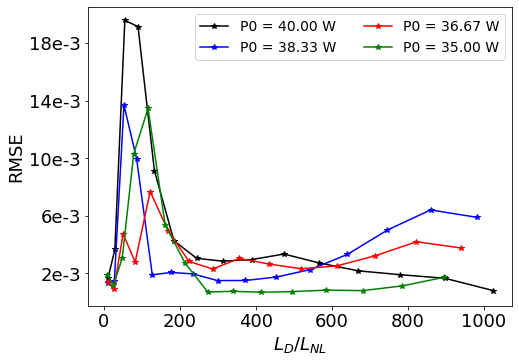

In [19]:
fontsize = 18

def nl_ratio(P0,T0):
  return (18.4e-3/5.23e-27)*P0*T0**2

P100 = np.linspace(35,40,40)
T_fwhm = np.linspace(0.5e-12, 5e-12, 75)
T0 = T_fwhm/(2*np.log(1+np.sqrt(2)))

# plot
plt.figure(figsize=[7.6, 5.5])
plt.plot(nl_ratio(P100[39], T0[0:75:5]), score_step[45:60], '*-k', label='P0 = %.2f W' % P100[39])
plt.plot(nl_ratio(P100[26], T0[0:75:5]), score_step[30:45], '*-b', label='P0 = %.2f W' % P100[26])
plt.plot(nl_ratio(P100[13], T0[0:75:5]), score_step[15:30], '*-r', label='P0 = %.2f W' % P100[13])
plt.plot(nl_ratio(P100[00], T0[0:75:5]), score_step[00:15], '*-g', label='P0 = %.2f W' % P100[00])
plt.xticks(fontsize=fontsize)
plt.yticks([2e-3,6e-3,10e-3,14e-3,18e-3],['2e-3','6e-3','10e-3','14e-3','18e-3'],fontsize=fontsize)
plt.xlabel(r'$L_D/L_{NL}$', fontsize=fontsize)
plt.ylabel('RMSE', fontsize=fontsize)
plt.legend(fontsize=14, ncol=2)

plt.savefig('figure.eps', bbox_inches = "tight")

In [28]:
def index(I, num=75):
  m = int(I/num)                          # power
  n = I - int(I/num)*num                  # timewidth
  return m, n

#@title Pulse Profile { run: "auto", vertical-output: true, display-mode: "form" }
I = 52 #@param {type:"slider", min:0, max:99, step:1}

# inputs
P0     = np.linspace(35, 40, num=40)      # Peak power
T_FWHM = np.linspace(0.5, 5, num=75)        # FWHM

# for reproducibility
np.random.seed(0)

r = np.arange(3000)
np.random.shuffle(r)
r = r[2900:]

m,n = index(r[I])

print(r.shape)
print('P0 = %.2f' % P0[m], 'W;', 'T_FWHM = %.2f' % T_FWHM[n], 'ps')

(100,)
P0 = 40.00 W; T_FWHM = 0.80 ps


In [25]:
# data params
ts = 10             # window size
N = 101 - ts        # steps

# load data:
sech40_data = sio.loadmat(path + '/data/sech_P40W_T5ps_time.mat')['data']

# test dataset:
x_test, y_test, scaler = load_data(sech40_data, ts=ts)

# build model:
model = build_model(x_test, y_test, units=512, a='tanh')
model.load_weights(path + '/nets/LSTM512_2Dense161_ts10_sech40_time.h5')

# predict:
y_pred = predict(model, x_test, N)

# metrics:
metrics(y_test, y_pred)

RMSE = 0.005328
NRMSE = 0.138838
MSE  = 0.000051
MAE  = 0.001915
R2   = 0.951710


In [26]:
y_true = scaler.inverse_transform(y_test)
y_fake = scaler.inverse_transform(y_pred)

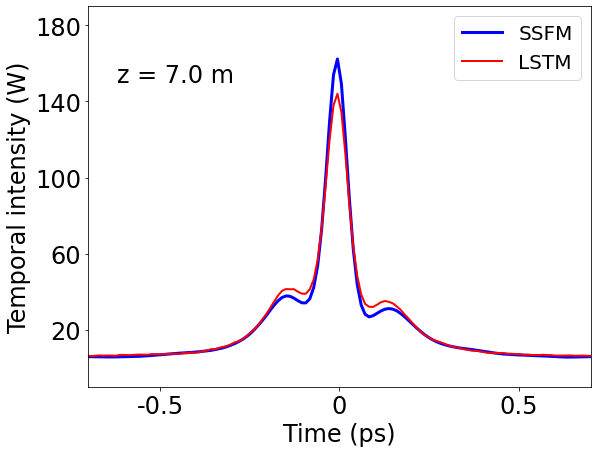

In [39]:
fontsize = 24
t = np.linspace(-0.7,0.7,128)

deltaz = .13; M = 101
L = np.linspace(deltaz*ts, deltaz*M, N)

# plot
plt.figure(figsize=[9, 7])
plt.plot(t, y_true[I*N + 43], 'b', label='SSFM', lw=3)
plt.plot(t, y_fake[I*N + 43], 'r', label='LSTM', lw=2)
plt.xticks([-0.5,0,0.5], ['-0.5','0','0.5'], fontsize=fontsize)
plt.yticks([20,60,100,140,180], fontsize=fontsize)
plt.xlabel('Time (ps)', fontsize=fontsize)
plt.ylabel('Temporal intensity (W)', fontsize=fontsize)
plt.xlim([-.7,.7])
plt.ylim([-10, 190])
plt.legend(fontsize=20)

plt.text(-.62, 150, 'z = %.1f m' % L[43], fontsize=fontsize)

plt.savefig('figure5.eps', bbox_inches = "tight")

In [40]:
y_pred = predict(model, x_test[I*N:I*N+N], N)
metrics(y_test[I*N:I*N+N], y_pred)

RMSE = 0.003655
NRMSE = 0.108459
MSE  = 0.000025
MAE  = 0.002516
R2   = 0.933603


### Po < 50 W

In [6]:
# data params
ts = 10             # window size
N = 101 - ts        # steps

# load data:
sech50_data = sio.loadmat(path + '/data/sech_P50W_T5ps_time.mat')['data']

# test dataset
x_test, y_test, scaler = load_data(sech50_data, ts=ts, split=False, shuffle=False)

# build model
model = build_model(x_test, y_test, units=512, a='tanh')
# model.load_weights(path + '/nets/LSTM512_2Dense161_ts10_sech_time.h5')
model.load_weights(path + '/nets/LSTM512_2Dense161_ts10_sech50_time.h5')

In [7]:
from sklearn.metrics import mean_squared_error

score_step = []

x_evo = np.split(x_test, 3000)
y_evo = np.split(y_test, 3000)
n_evo = -1

for n in range(0,3000,3):
  if (n%75 == 0): # count simulations
    n_evo += 1

  # Metrics
  if n_evo%13 == 0: # predict simulation in 5W steps
    y_pred = predict(model, x_evo[n], N)
    RMSE = mean_squared_error(y_evo[n], y_pred, squared=False)

    score_step.append(RMSE)

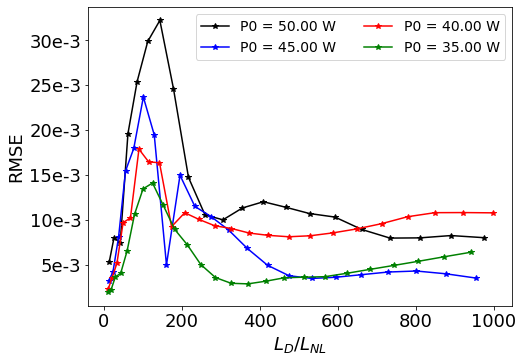

In [12]:
fontsize = 18

def nl_ratio(P0,T0):
  return (18.4e-3/5.23e-27)*P0*T0**2

P100 = np.linspace(35,50,40)
T_fwhm = np.linspace(0.5e-12, 5e-12, 75)
T0 = T_fwhm/(2*np.log(1+np.sqrt(2)))

# plot
plt.figure(figsize=[7.6, 5.5])
plt.plot(nl_ratio(P100[39], T0[0:75-4*3:3]), score_step[75:100-4], '*-k', label='P0 = %.2f W' % P100[39])
plt.plot(nl_ratio(P100[26], T0[0:75-3*3:3]), score_step[50:75-3], '*-b', label='P0 = %.2f W' % P100[26])
plt.plot(nl_ratio(P100[13], T0[0:75-1*3:3]), score_step[25:50-1], '*-r', label='P0 = %.2f W' % P100[13])
plt.plot(nl_ratio(P100[00], T0[0:75:3]), score_step[00:25], '*-g', label='P0 = %.2f W' % P100[00])
plt.xticks(fontsize=fontsize)
plt.yticks([5e-3,10e-3,15e-3,20e-3,25e-3,30e-3],['5e-3','10e-3','15e-3','20e-3','25e-3','30e-3'],fontsize=fontsize)
plt.xlabel(r'$L_D/L_{NL}$', fontsize=fontsize)
plt.ylabel('RMSE', fontsize=fontsize)
plt.legend(fontsize=14, ncol=2)

plt.savefig('figure4a.eps', bbox_inches = "tight")

### Po < 70 W

In [13]:
# data params
ts = 10             # window size
N = 101 - ts        # steps

# load data:
sech70_data = sio.loadmat(path + '/data/sech_P70W_T5ps_time.mat')['data']

# test dataset
x_test, y_test, scaler = load_data(sech70_data, ts=ts, split=False, shuffle=False)

# build model
model = build_model(x_test, y_test, units=512, a='tanh')
model.load_weights(path + '/nets/LSTM512_2Dense161_ts10_sech70_time.h5')

In [14]:
from sklearn.metrics import mean_squared_error

score_step = []

x_evo = np.split(x_test, 3000)
y_evo = np.split(y_test, 3000)
n_evo = -1

for n in range(0,3000,3):
  if (n%75 == 0): # count simulations
    n_evo += 1

  # Metrics
  if n_evo%13 == 0: # predict simulation in 5W steps
    y_pred = predict(model, x_evo[n], N)
    RMSE = mean_squared_error(y_evo[n], y_pred, squared=False)

    score_step.append(RMSE)

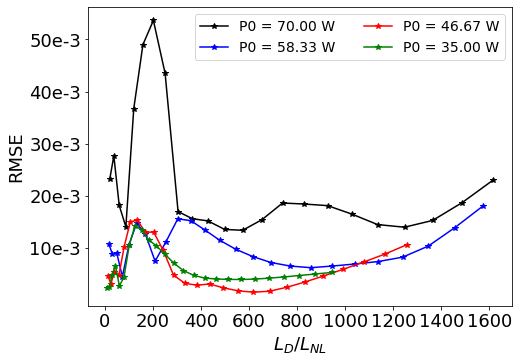

In [20]:
fontsize = 18

def nl_ratio(P0,T0):
  return (18.4e-3/5.23e-27)*P0*T0**2

P100 = np.linspace(35,70,40)
T_fwhm = np.linspace(0.5e-12, 5e-12, 75)
T0 = T_fwhm/(2*np.log(1+np.sqrt(2)))

# plot
plt.figure(figsize=[7.6, 5.5])
plt.plot(nl_ratio(P100[39], T0[0:75-3*2:3]), score_step[75:100-2], '*-k', label='P0 = %.2f W' % P100[39])
plt.plot(nl_ratio(P100[26], T0[0:75:3]), score_step[50:75], '*-b', label='P0 = %.2f W' % P100[26])
plt.plot(nl_ratio(P100[13], T0[0:75:3]), score_step[25:50], '*-r', label='P0 = %.2f W' % P100[13])
plt.plot(nl_ratio(P100[00], T0[0:75:3]), score_step[00:25], '*-g', label='P0 = %.2f W' % P100[00])
plt.xticks(fontsize=fontsize)
plt.yticks([10e-3,20e-3,30e-3,40e-3,50e-3],['10e-3','20e-3','30e-3','40e-3','50e-3'],fontsize=fontsize)
plt.xlabel(r'$L_D/L_{NL}$', fontsize=fontsize)
plt.ylabel('RMSE', fontsize=fontsize)
plt.legend(fontsize=14, ncol=2)

plt.savefig('figure4b.eps', bbox_inches = "tight")